In [ ]:

! pip install python-Levenshtein
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from functools import lru_cache
from Levenshtein import distance as levenshtein_distance
from collections import defaultdict
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Прочтение таблиц

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/BioCode/King_Charles.xlsx")
df.head()

,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene
0,213,225,0.000100,TGTGCCAGCAGTTTTCGCCGAGAGATGAACACTGAAGCTTTCTTT,CASSFRREMNTEAFF,TRBV12-4,TRBJ1-1
1,214,225,0.000100,TGTGCCAGCTCCCAGGGGGCAGTCGGGGAGCTGTTTTTT,CASSQGAVGELFF,TRBV2,TRBJ2-2
2,212,226,0.000100,TGTGCCAGCAGTTTGTGGACCTACAATGAGCAGTTCTTC,CASSLWTYNEQFF,TRBV12-4,TRBJ2-1
3,211,226,0.000100,TGTGCCAGCATTTTGACAGGGGCGAACACCGGGGAGCTGTTTTTT,CASILTGANTGELFF,TRBV2,TRBJ2-2
4,207,227,0.000101,TGTGCCAGCAGCCTTTACGGGGGGACAGGGCTACATGATGAGCAGT...,CASSLYGGTGLHDEQFF,TRBV7-6,TRBJ2-1


In [ ]:
database = pd.read_excel("/content/drive/MyDrive/BioCode/vdjdb.slim.xlsx")

In [ ]:
database_exp = database.rename(columns={'cdr3': 'CDR3.amino.acid.sequence'})

In [ ]:
df = df.sort_values(by='Read.count', ascending=False)
df

,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene
214,0,5435,2.416853e-03,TGCGCCAGCAGCTTGGGAGGGGATACGCAGTATTTT,CASSLGGDTQYF,TRBV5-1,TRBJ2-3
213,1,4969,2.209631e-03,TGCGCCAGCAGGGTGGGACTAGCGGGAGGGCCTGTAGATGAGCAGT...,CASRVGLAGGPVDEQFF,TRBV5-1,TRBJ2-1
212,2,4400,1.956606e-03,TGTGCCAGCAGCTCCTATGAATCCCCCTACAATGAGCAGTTCTTC,CASSSYESPYNEQFF,TRBV11-2,TRBJ2-1
211,3,2794,1.242445e-03,TGCGCCAGCAGCTTGGAGGGGACAGACTATGGCTACACCTTC,CASSLEGTDYGYTF,TRBV5-1,TRBJ1-2
210,4,2650,1.178410e-03,TGTGCCAGCAGCTTTTTGTCCAGTGAAGCTTTCTTT,CASSFLSSEAFF,TRBV7-2,TRBJ1-1
...,...,...,...,...,...,...,...
431750,906994,1,4.446832e-07,TGTGCCAGCACCTACACGGGAGTGGCCTACGAGCAGTACTTC,CASTYTGVAYEQYF,TRBV12-4,TRBJ2-7
431751,1089087,1,4.446832e-07,TGTGCCAGCACCTACACGGGGGGGAACATTCAGTACTTC,CASTYTGGNIQYF,TRBV6-1,TRBJ2-4
431752,687953,1,4.446832e-07,TGTGCCAGCACCTACACTAGCGGGGCTGGCGGGGAGCTGTTTTTT,CASTYTSGAGGELFF,TRBV2,TRBJ2-2
431753,529877,1,4.446832e-07,TGTGCCAGCACCTACACTAGCGGGGGGACCACAGATACGCAGTATTTT,CASTYTSGGTTDTQYF,TRBV12-3,TRBJ2-3


In [ ]:
data_claster = df[:3000]
data_claster

,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene
214,0,5435,0.002417,TGCGCCAGCAGCTTGGGAGGGGATACGCAGTATTTT,CASSLGGDTQYF,TRBV5-1,TRBJ2-3
213,1,4969,0.002210,TGCGCCAGCAGGGTGGGACTAGCGGGAGGGCCTGTAGATGAGCAGT...,CASRVGLAGGPVDEQFF,TRBV5-1,TRBJ2-1
212,2,4400,0.001957,TGTGCCAGCAGCTCCTATGAATCCCCCTACAATGAGCAGTTCTTC,CASSSYESPYNEQFF,TRBV11-2,TRBJ2-1
211,3,2794,0.001242,TGCGCCAGCAGCTTGGAGGGGACAGACTATGGCTACACCTTC,CASSLEGTDYGYTF,TRBV5-1,TRBJ1-2
210,4,2650,0.001178,TGTGCCAGCAGCTTTTTGTCCAGTGAAGCTTTCTTT,CASSFLSSEAFF,TRBV7-2,TRBJ1-1
...,...,...,...,...,...,...,...
842,3092,26,0.000012,TGTGCCATCGGGAGGAGCACAGATACGCAGTATTTT,CAIGRSTDTQYF,TRBV24-1,TRBJ2-3
841,3008,26,0.000012,TGTGCCATCAGTGGATCTACGCACAGTTTAAACGAGCAGTACTTC,CAISGSTHSLNEQYF,TRBV10-3,TRBJ2-7
840,2990,26,0.000012,TGTGCCATCAGTGAGCCCGGGACAGCCAACACCGGGGAGCTGTTTTTT,CAISEPGTANTGELFF,TRBV10-3,TRBJ2-2
838,3010,26,0.000012,TGTGCCAGTAGTACTCCAGGGGGCGCCCCTAATGAGCAGTTCTTC,CASSTPGGAPNEQFF,TRBV19,TRBJ2-1


# Функция кластеризации

In [ ]:
# Кэшированная функция для вычисления расстояния Левенштейна
@lru_cache(maxsize=None)
def cached_levenshtein_distance(seq1, seq2):
    return levenshtein_distance(seq1, seq2)

# Функция для кластеризации последовательностей
def cluster_sequences(sequences, max_distance=1):
    clusters = []
    for seq in sequences:
        added_to_cluster = False
        for cluster in clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for existing_seq in cluster):
                cluster.append(seq)
                added_to_cluster = True
                break
        if not added_to_cluster:
            clusters.append([seq])
    return clusters

# Функция для объединения кластеров
def merge_clusters(clusters, max_distance=1):
    merged_clusters = []
    for cluster in clusters:
        added_to_cluster = False
        for merged_cluster in merged_clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for seq in cluster for existing_seq in merged_cluster):
                merged_cluster.extend(cluster)
                added_to_cluster = True
                break
        if not added_to_cluster:
            merged_clusters.append(cluster)
    return merged_clusters

# Пример последовательностей аминокислот
sequences = data_claster['CDR3.amino.acid.sequence']

# Разделение данных на части
chunk_size = len(sequences) // 100
chunks = [sequences[i:i + chunk_size] for i in range(0, len(sequences), chunk_size)]

# Кластеризация каждой части
all_clusters = []
for chunk in chunks:
    all_clusters.extend(cluster_sequences(chunk, max_distance=1))

# Объединение кластеров
final_clusters = merge_clusters(all_clusters, max_distance=1)

# Вывод результатов
# Создание DataFrame
cluster_data = []
for i, cluster in enumerate(final_clusters):
    for seq in cluster:
        cluster_data.append({'Cluster': i + 1, 'Sequence': seq})

results_df = pd.DataFrame(cluster_data)

In [ ]:
# Создание нового DataFrame с данными из data_claster и номером кластера
cluster_assignments = {}
for i, cluster in enumerate(final_clusters):
  for seq in cluster:
    cluster_assignments[seq] = i + 1

results_df = data_claster.copy()
results_df['Cluster'] = results_df['CDR3.amino.acid.sequence'].map(cluster_assignments)

# Вывод нового DataFrame results_df
results_df


,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene,Cluster
214,0,5435,0.002417,TGCGCCAGCAGCTTGGGAGGGGATACGCAGTATTTT,CASSLGGDTQYF,TRBV5-1,TRBJ2-3,1
213,1,4969,0.002210,TGCGCCAGCAGGGTGGGACTAGCGGGAGGGCCTGTAGATGAGCAGT...,CASRVGLAGGPVDEQFF,TRBV5-1,TRBJ2-1,2
212,2,4400,0.001957,TGTGCCAGCAGCTCCTATGAATCCCCCTACAATGAGCAGTTCTTC,CASSSYESPYNEQFF,TRBV11-2,TRBJ2-1,3
211,3,2794,0.001242,TGCGCCAGCAGCTTGGAGGGGACAGACTATGGCTACACCTTC,CASSLEGTDYGYTF,TRBV5-1,TRBJ1-2,4
210,4,2650,0.001178,TGTGCCAGCAGCTTTTTGTCCAGTGAAGCTTTCTTT,CASSFLSSEAFF,TRBV7-2,TRBJ1-1,5
...,...,...,...,...,...,...,...,...
842,3092,26,0.000012,TGTGCCATCGGGAGGAGCACAGATACGCAGTATTTT,CAIGRSTDTQYF,TRBV24-1,TRBJ2-3,2844
841,3008,26,0.000012,TGTGCCATCAGTGGATCTACGCACAGTTTAAACGAGCAGTACTTC,CAISGSTHSLNEQYF,TRBV10-3,TRBJ2-7,2845
840,2990,26,0.000012,TGTGCCATCAGTGAGCCCGGGACAGCCAACACCGGGGAGCTGTTTTTT,CAISEPGTANTGELFF,TRBV10-3,TRBJ2-2,2846
838,3010,26,0.000012,TGTGCCAGTAGTACTCCAGGGGGCGCCCCTAATGAGCAGTTCTTC,CASSTPGGAPNEQFF,TRBV19,TRBJ2-1,2847


# Подсчёт Total Read Proportion

In [ ]:

# Подсчет количества последовательностей в каждом кластере
cluster_counts = {i + 1: len(cluster) for i, cluster in enumerate(final_clusters)}
# Подсчет суммарного Read.proportion для каждого кластера
cluster_proportions = {}
for index, row in data_claster.iterrows():
  seq = row['CDR3.amino.acid.sequence']
  proportion = row['Read.proportion']
  for i, cluster in enumerate(final_clusters):
    if seq in cluster:
      cluster_proportions[i + 1] = cluster_proportions.get(i + 1, 0) + proportion
      break

# Создание DataFrame с суммарными пропорциями, номерами кластеров и количеством последовательностей
proportions_data = []
for cluster_number, total_proportion in cluster_proportions.items():
  proportions_data.append({'Cluster': cluster_number,
               'Total Read Proportion': total_proportion,
               'Sequence Count': cluster_counts[cluster_number]})



# Сортировка по Sequence Count

In [ ]:
proportions_df = pd.DataFrame(proportions_data)
proportions_df = proportions_df.sort_values(by='Sequence Count', ascending=False)
proportions_df

,Cluster,Total Read Proportion,Sequence Count
18,19,0.001077,10
378,379,0.000273,8
66,67,0.000307,6
0,1,0.002485,5
291,292,0.000200,5
...,...,...,...
990,991,0.000028,1
991,992,0.000028,1
992,993,0.000028,1
993,994,0.000028,1


# Сортировка по Total Read Proportion

In [ ]:
proportions_df_sorted = proportions_df.sort_values(by='Total Read Proportion', ascending=False)
#proportions_df_sorted = proportions_df_sorted.loc[proportions_df_sorted['Sequence Count'] > 1]
proportions_df_sorted

,Cluster,Total Read Proportion,Sequence Count
0,1,0.002485,5
1,2,0.002210,1
2,3,0.001957,1
3,4,0.001323,4
4,5,0.001178,1
...,...,...,...
2823,2824,0.000012,1
2827,2828,0.000012,1
2842,2843,0.000012,1
2841,2842,0.000012,1


# Выбор кластера

In [ ]:
full = pd.merge(results_df, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [ ]:
full = full[['gene', 'Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,gene,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,TRB,1,CASSLGGDTQYF,0.002417,TRBV5-1,TRBJ2-3,TRBV28*01,TRBJ2-1*01,MHCI,HomoSapiens,HIV-1,Pol
1,TRB,19,CASSLSTDTQYF,0.000232,TRBV7-6,TRBJ2-3,TRBV12-3*01,TRBJ2-3*01,MHCI,HomoSapiens,SARS-CoV-2,ORF1ab
2,TRB,19,CASSLSTDTQYF,0.000232,TRBV7-6,TRBJ2-3,TRBV28*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,pp65
3,TRB,19,CASSLSTDTQYF,0.000232,TRBV7-6,TRBJ2-3,TRBV5-4*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,IE1
4,TRB,19,CASSLSTDTQYF,0.000232,TRBV7-6,TRBJ2-3,TRBV5-4*01,TRBJ2-3*01,MHCI,HomoSapiens,EBV,EBNA3A
...,...,...,...,...,...,...,...,...,...,...,...,...
142,TRB,2733,CASSPTGGNTEAFF,0.000012,TRBV18,TRBJ1-1,TRBV4-1*01,TRBJ1-1*01,MHCI,HomoSapiens,InfluenzaA,M
143,TRB,2733,CASSPTGGNTEAFF,0.000012,TRBV18,TRBJ1-1,TRBV9*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
144,TRB,19,CASSYSTDTQYF,0.000012,TRBV2,TRBJ2-3,TRBV6-6*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,pp65
145,TRB,67,CASSQETQYF,0.000012,TRBV3-1,TRBJ2-5,TRBV3-1*01,TRBJ2-5*01,MHCI,HomoSapiens,CMV,IE1


In [ ]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7]) & (full['gene'] == 'TRB')]
full_vj

,gene,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
11,TRB,188,CSVGTGGTNEKLFF,0.000111,TRBV29-1,TRBJ1-4,TRBV29-1*01,TRBJ1-4*01,MHCI,HomoSapiens,EBV,BMLF1
12,TRB,188,CSVGTGGTNEKLFF,0.000111,TRBV29-1,TRBJ1-4,TRBV29-1*01,TRBJ1-4*01,MHCII,HomoSapiens,InfluenzaA,NP
15,TRB,239,CASSLEGDQPQHF,0.000090,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,CMV,IE1
16,TRB,239,CASSLEGDQPQHF,0.000090,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,InfluenzaA,NP
17,TRB,239,CASSLEGDQPQHF,0.000090,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,SARS-CoV-2,Spike
25,TRB,239,CASSLEGDQPQHF,0.000067,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,CMV,IE1
26,TRB,239,CASSLEGDQPQHF,0.000067,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,InfluenzaA,NP
27,TRB,239,CASSLEGDQPQHF,0.000067,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,SARS-CoV-2,Spike
28,TRB,354,CASSQDGAGGLGEQFF,0.000066,TRBV4-2,TRBJ2-1,TRBV4-2*01,TRBJ2-1*01,MHCI,HomoSapiens,EBV,BMLF1
33,TRB,239,CASSLEGDQPQHF,0.000051,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,CMV,IE1


In [ ]:
full_total_prop = pd.merge(proportions_df_sorted, full_vj , on='Cluster', how='inner')
full_total_prop

,Cluster,Total Read Proportion,Sequence Count,gene,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,50,0.000346,4,TRB,CASSFTDTQYF,0.000019,TRBV12-4,TRBJ2-3,TRBV12-4*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,IE1
1,67,0.000307,6,TRB,CASSQETQYF,0.000012,TRBV3-1,TRBJ2-5,TRBV3-1*01,TRBJ2-5*01,MHCI,HomoSapiens,CMV,IE1
2,71,0.000264,3,TRB,CASSLGTGSYEQYF,0.000018,TRBV12-4,TRBJ2-7,"TRBV12-4*01,TRBV5-4*01",TRBJ2-7*01,MHCI,HomoSapiens,CMV,IE1
3,92,0.000263,5,TRB,CASSLNTGELFF,0.000012,TRBV5-4,TRBJ2-2,TRBV5-4*01,TRBJ2-2*01,MHCI,HomoSapiens,CMV,IE1
4,239,0.000207,3,TRB,CASSLEGDQPQHF,0.000090,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,CMV,IE1
5,239,0.000207,3,TRB,CASSLEGDQPQHF,0.000090,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,InfluenzaA,NP
6,239,0.000207,3,TRB,CASSLEGDQPQHF,0.000090,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,SARS-CoV-2,Spike
7,239,0.000207,3,TRB,CASSLEGDQPQHF,0.000067,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,CMV,IE1
8,239,0.000207,3,TRB,CASSLEGDQPQHF,0.000067,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,InfluenzaA,NP
9,239,0.000207,3,TRB,CASSLEGDQPQHF,0.000067,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,SARS-CoV-2,Spike


In [ ]:
value_counts = full_vj['Cluster'].value_counts()
value_counts

,count
Cluster,
239,9
188,2
71,1
92,1
2449,1
2160,1
1091,1
478,1
1800,1


In [ ]:
full_full = pd.merge(proportions_df_sorted,value_counts, on = 'Cluster', how='inner' )
full_full

,Cluster,Total Read Proportion,Sequence Count,count
0,50,0.000346,4,1
1,67,0.000307,6,1
2,71,0.000264,3,1
3,92,0.000263,5,1
4,239,0.000207,3,9
5,188,0.000134,2,2
6,478,0.000068,2,1
7,354,0.000066,1,1
8,946,0.000058,2,1
9,1091,0.000054,3,1


In [64]:
full_full['Total Read Proportion'].sum()

0.001939708074379272

# Обработка для одного выбранного кластера

In [ ]:
results_df_one_cluster = results_df.loc[results_df['Cluster'] == 50]
results_df_one_cluster = results_df_one_cluster.rename(columns={'Sequence': 'CDR3.amino.acid.sequence'})
results_df_one_cluster

,Rank,Read.count,Read.proportion,CDR3.nucleotide.sequence,CDR3.amino.acid.sequence,bestVGene,bestJGene,Cluster
165,49,652,0.000290,TGTGCCAGCAGTAACACAGATACGCAGTATTTT,CASSNTDTQYF,TRBV28,TRBJ2-3,50
98750,1597,45,0.000020,TGTGCCAGCAGCAGAACAGATACGCAGTATTTT,CASSRTDTQYF,TRBV12-4,TRBJ2-3,50
98686,1692,43,0.000019,TGTGCCAGCAGTTTCACAGATACGCAGTATTTT,CASSFTDTQYF,TRBV12-4,TRBJ2-3,50
74064,1923,39,0.000017,TGTGCCAGCAGTTACACAGATACGCAGTATTTT,CASSYTDTQYF,TRBV12-4,TRBJ2-3,50


In [ ]:
full = pd.merge(results_df_one_cluster, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [ ]:
full = full[['gene','Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,gene,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,TRB,50,CASSFTDTQYF,0.000019,TRBV12-4,TRBJ2-3,TRBV28*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,pp65
1,TRB,50,CASSFTDTQYF,0.000019,TRBV12-4,TRBJ2-3,TRBV12-4*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,IE1


# Разборки с V и J

In [ ]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7])& (full['gene'] == 'TRB')]
full_vj

,gene,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
1,TRB,50,CASSFTDTQYF,0.000019,TRBV12-4,TRBJ2-3,TRBV12-4*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,IE1


# Без кластеризации

In [ ]:
full = pd.merge(df, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [ ]:
full = full[['CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,CASSLGGDTQYF,2.416853e-03,TRBV5-1,TRBJ2-3,TRBV28*01,TRBJ2-1*01,MHCI,HomoSapiens,HIV-1,Pol
1,CASSLSTDTQYF,2.321246e-04,TRBV7-6,TRBJ2-3,TRBV12-3*01,TRBJ2-3*01,MHCI,HomoSapiens,SARS-CoV-2,ORF1ab
2,CASSLSTDTQYF,2.321246e-04,TRBV7-6,TRBJ2-3,TRBV28*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,pp65
3,CASSLSTDTQYF,2.321246e-04,TRBV7-6,TRBJ2-3,TRBV5-4*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,IE1
4,CASSLSTDTQYF,2.321246e-04,TRBV7-6,TRBJ2-3,TRBV5-4*01,TRBJ2-3*01,MHCI,HomoSapiens,EBV,EBNA3A
...,...,...,...,...,...,...,...,...,...,...
23392,CASTVSSYNEQFF,4.446832e-07,TRBV14,TRBJ2-1,TRBV6-6*01,TRBJ2-1*01,MHCI,HomoSapiens,SARS-CoV-2,Nucleocapsid
23393,CASTGAGELFF,4.446832e-07,TRBV7-9,TRBJ2-2,TRBV12-3*01,TRBJ2-2*01,MHCI,HomoSapiens,InfluenzaA,M
23394,CASTGGNEQFF,4.446832e-07,TRBV11-2,TRBJ2-1,TRBV25-1*01,TRBJ2-1*01,MHCI,HomoSapiens,InfluenzaA,NP
23395,CASTGTAYGYTF,4.446832e-07,TRBV25-1,TRBJ1-2,TRBV19*01,TRBJ1-2*01,MHCI,HomoSapiens,HIV-1,Gag


In [ ]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7])]
full_vj

,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
11,CSVGTGGTNEKLFF,1.107261e-04,TRBV29-1,TRBJ1-4,TRBV29-1*01,TRBJ1-4*01,MHCI,HomoSapiens,EBV,BMLF1
12,CSVGTGGTNEKLFF,1.107261e-04,TRBV29-1,TRBJ1-4,TRBV29-1*01,TRBJ1-4*01,MHCII,HomoSapiens,InfluenzaA,NP
15,CASSLEGDQPQHF,8.982600e-05,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,CMV,IE1
16,CASSLEGDQPQHF,8.982600e-05,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,InfluenzaA,NP
17,CASSLEGDQPQHF,8.982600e-05,TRBV5-1,TRBJ1-5,TRBV5-1*01,TRBJ1-5*01,MHCI,HomoSapiens,SARS-CoV-2,Spike
...,...,...,...,...,...,...,...,...,...,...
23314,CASNRGNTGELFF,4.446832e-07,TRBV12-3,TRBJ2-2,TRBV12-3*01,TRBJ2-2*01,MHCI,HomoSapiens,CMV,IE1
23328,CASTWGNQPQHF,4.446832e-07,TRBV12-4,TRBJ1-5,TRBV12-4*01,TRBJ1-5*01,MHCII,HomoSapiens,InfluenzaA,M1
23333,CASTRGGETQYF,4.446832e-07,TRBV12-3,TRBJ2-5,TRBV12-3*01,TRBJ2-5*01,MHCI,HomoSapiens,CMV,pp65
23339,CASTLGNTEAFF,4.446832e-07,TRBV12-3,TRBJ1-1,TRBV12-4*01,TRBJ1-1*01,MHCI,HomoSapiens,InfluenzaA,M


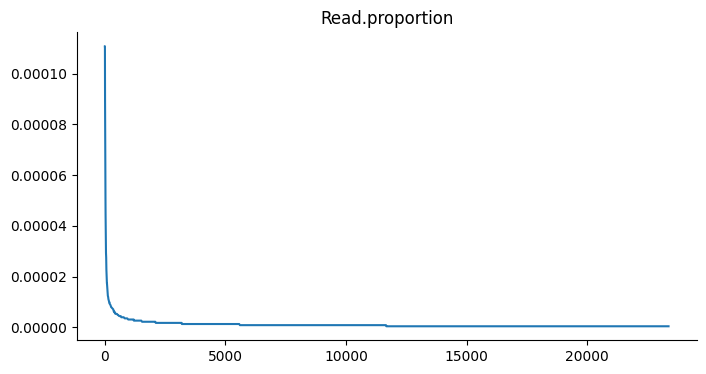

In [ ]:
# @title Read.proportion

from matplotlib import pyplot as plt
full_vj['Read.proportion'].plot(kind='line', figsize=(8, 4), title='Read.proportion')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
full_vj['antigen.species'].value_counts()

,count
antigen.species,
CMV,917
EBV,260
SARS-CoV-2,229
InfluenzaA,209
HomoSapiens,145
HIV-1,94
DENV,52
HCV,47
YFV,26
